In [1]:
import pandas as pd

import numpy as np
import os, sys

# pvlib imports
import pvlib

from pvlib.pvsystem import PVSystem

from pvlib.location import Location

from pvlib.modelchain import ModelChain
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS

from timeseries_functions import timeseries_plotter, timesteplen_calculator, cleaner_per_day, remove_duplicate_index
from dtw import *

import plotly.express as px
import seaborn as sns
import h5py



Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



Todos:

* Validation Period has to be equal for fair comparison

* Get real tilt and azimuth of each system; random choices seem to reduce the cost?!

In [2]:


def physical_profile(row):

    "Pass a dataset for PV Meta Data: Location, Tilt, Azimuth, Capacity and a Dataset for irradiance: DNI, DHI, GHI to calculate profiles with PV Watts"
    
    index, latitude, longitude, tilt, azimuth, capacity = row

    temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

    location = Location(latitude=latitude, longitude=longitude)

    pvwatts_system = PVSystem(surface_tilt= tilt , surface_azimuth=azimuth,
        module_parameters={'pdc0': capacity, 'gamma_pdc': -0.004},
        inverter_parameters={'pdc0': capacity},
        temperature_model_parameters=temperature_model_parameters)
    
    mc = ModelChain(pvwatts_system, location, aoi_model='physical', spectral_model='no_loss')
    mc.run_model(df_irr)
    results = mc.results.ac

    df_results = pd.Series(results)
    df_results.index = df_results.index.tz_localize(None)
    df_results.index.name = "timestamp"

    return df_results

In [5]:
os.getcwd()

'/Users/nikolaushouben/Library/Mobile Documents/com~apple~CloudDocs/PhD_Icloud/PhD_Research/Paper_2_Collaborative Forecasting/Code/Collaborative_PV_Forecasting'

# Data Imports

In [3]:
df_power = pd.read_csv("../../Input_Data/PV_System_Power.csv", index_col=0, parse_dates=True)

In [4]:
original_timesteplen = round(timesteplen_calculator(df_power),10)
original_timestep = round(original_timesteplen/10)*10
selected_systems= df_power.columns
target_timesteplen = "15T"


In [5]:
df_power = df_power.resample(target_timesteplen).mean()

In [6]:
df_power.columns = [int(col) for col in df_power.columns]

In [7]:
df_meta = pd.read_csv("../../Data/System/PV system information dataset TU WIEN.csv", sep = ";", index_col=0)
df_meta = df_meta.iloc[:,1:]
df_meta["tilt"] = df_meta["tilt"].str.replace(",",".")
df_meta["azimuth"] = df_meta["azimuth"].str.replace(",",".")
df_meta = df_meta.astype("float")
total_cap = df_meta["estimated capacity"].sum() / 10**6


In [10]:
df_meta_infer = pd.read_csv("../../Input_Data/Meta_Data_PV_Optimised.csv", index_col=0)

In [15]:
df_meta["tilt"] = df_meta_infer["tilt_finetuned"]
df_meta["azimuth"] = df_meta_infer["azimuth_finetuned"]

In [17]:

selected_systems = [int(index) for index in selected_systems]
df_meta = df_meta.loc[selected_systems,:]

In [19]:
df_irr = pd.read_csv("../../Data/Meteo/GHI_DNI_DHI.csv", index_col=0, parse_dates=True)
df_irr = df_irr.iloc[:,2:]
print(df_irr.columns)
df_irr.columns = ["dhi", "dni", "ghi"]
df_irr = df_irr.resample(target_timesteplen).mean()
df_irr = df_irr.tz_localize(None)

Index(['Dhi', 'Dni', 'Ghi'], dtype='object')


In [22]:
first_timestep = df_irr.index[0]
last_timestep = df_irr.index[-1]
df_power = df_power[first_timestep:last_timestep]

In [24]:
def entsoe_data_manipulation(df, technology= "Price"): #ist ausbaufähig ;) 

    index_name = df.index.name

    cols = [string for string in df.columns if technology in string] 
    df = df[cols].reset_index()
    df[["timestamp"]] = df[index_name].str.split("-", expand= True)[0]
    df.index = pd.DatetimeIndex(df["timestamp"])
    df = df.drop([index_name, "timestamp"], axis = 1)
    return df

df_price_2015 = pd.read_csv("../../Data/Price/Imbalance_201501010000-201601010000.csv", index_col=0)
df_price_2016 = pd.read_csv("../../Data/Price/Imbalance_201601010000-201701010000.csv", index_col=0)
df_price_2015 = entsoe_data_manipulation(df_price_2015, "Price")
df_price_2016 = entsoe_data_manipulation(df_price_2016, "Price")
df_price = pd.concat([df_price_2015, df_price_2016],axis = 0)
df_price.columns = [col[0] for col in df_price.columns]
df_price = remove_duplicate_index(df_price, df_price.index.name)

In [66]:
df_price = df_price.astype("int")

# Best Case (Full Information)

In [67]:
df_full_info = df_meta.reset_index().apply(physical_profile, axis=1).transpose()
df_full_info.columns = df_meta.index

In [68]:
def error_calc(df_phys, df_measured, timesteplen, unit):

    "Input physical and measured timeseries of PV in Watts"
    
    df_copy = df_phys.copy()
    for column in df_phys:
        df_copy[column] -= df_measured[column]
   
    df_copy.dropna(inplace=True)

    df_errors_per_system = abs(df_copy).sum(0)

    df_errors_total = df_copy.sum(axis=1)

    if unit == "W":
        df_errors_total = pd.DataFrame(df_errors_total, columns=["error"])
        df_errors_total *= (60/int(timesteplen[:-1])) #from W to Wh
        df_errors_total /= 10**6 #from Wh to MWh
    else:
        raise ValueError("Unit should be in Watts")

    return df_errors_total, df_errors_per_system

In [69]:
df_errors_total, df_errors_per_system = error_calc(df_full_info, df_power, target_timesteplen, "W")

df_errors_per_system_total_information = pd.DataFrame(df_errors_per_system, columns=["total info"])

In [70]:
df_errors_total

,error
timestamp,
2015-01-01 00:00:00,0.0
2015-01-01 00:15:00,0.0
2015-01-01 00:30:00,0.0
2015-01-01 00:45:00,0.0
2015-01-01 01:00:00,0.0
...,...
2015-12-23 22:45:00,0.0
2015-12-23 23:00:00,0.0
2015-12-23 23:15:00,0.0


In [92]:
df_cost_full_info.describe()

,cost
count,13299.000000
mean,0.367707
std,1.127091
min,-3.237622
25%,0.000000
50%,0.000000
75%,0.461325
max,19.233977


In [91]:
fig = px.line(df_cost_full_info)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [96]:
def economic_cost_calculator(df_price, df_errors, total_cap):

    #Single Imbalance Pricing Scenario#
    
    df_merged = pd.merge(df_price, abs(df_errors), left_index=True, right_index=True)
    df_merged["cost"] = df_merged["+"] * df_merged["error"]
    df_cost = df_merged[["cost"]]

    #Dual Imbalance Pricing Scenario: The real case in The Netherlands#

    #df_merged = pd.merge(df_price, df_errors, left_index=True, right_index=True)
    #df_merged_pos = df_merged.loc[df_merged["error"] > 0][["error", "+"]].apply(np.prod, axis = 1)
    #df_cost_pos = pd.DataFrame(df_merged_pos, columns=["cost"])
    #df_merged_neg = df_merged.loc[df_merged["error"] < 0][["error", "-"]].apply(np.prod, axis = 1)
    #df_cost_neg = pd.DataFrame(df_merged_neg, columns=["cost"])
    #df_cost = pd.concat([df_cost_pos, df_cost_neg], axis = 0).reindex(df_merged.index).dropna()

    
    total_cost = (df_cost.sum(axis = 0) / total_cap)

    print("The total cost is {0} €/(MWp*a)".format(total_cost))

    return df_merged, df_cost, total_cost

In [97]:
df_merged, df_cost_full_info, total_cost = economic_cost_calculator(df_price, df_errors_total, total_cap)

The total cost is cost    67588.860663
dtype: float64 €/(MWp*a)


In [98]:
print("The best-case scenario, in which both tilt and azimuth are perfectly known gives a yearly cost of: {0} €/MWp".format(round(total_cost[0])))

The best-case scenario, in which both tilt and azimuth are perfectly known gives a yearly cost of: 67588.86066317697 €/MWp


In [137]:
cost_known = round(total_cost[0])

### Plotting some of the imbalances with their prices:

In [99]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_merged[df_merged.columns] = scaler.fit_transform(df_merged[df_merged.columns])

In [100]:
df_price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 69212 entries, 2015-01-01 00:00:00 to 2016-12-31 23:45:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   +       69212 non-null  int64
 1   -       69212 non-null  int64
dtypes: int64(2)
memory usage: 3.6 MB


In [ ]:
timeseries_plotter(df_merged,10)

In [81]:
df_price.describe()

,+,-
count,69212.000000,69212.000000
mean,38.278680,6.948506
std,62.897429,32.543088
min,0.000000,-433.000000
25%,0.000000,0.000000
50%,26.000000,13.000000
75%,44.000000,25.000000
max,737.000000,69.000000


# Case A (No Tilt)

### Checking if Tilt makes a difference

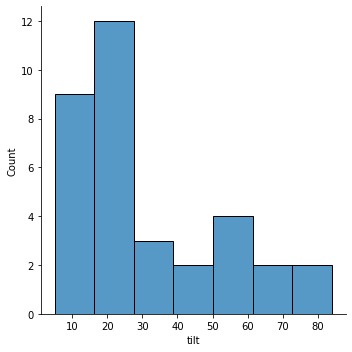

In [53]:
sns.displot(df_meta["tilt"])

None uniform distribution of tilts


- > Hypothesis: Guessing the tilt has a major impact on the accuracy of the physical modelling

### Cost Calculation

-> Assumption of a uniform distribution of tilts (just guessing randomly)

In [259]:
num_of_systems = df_meta.shape[0]
iters = 500


In [260]:
df_meta_tilts = df_meta.copy()

costs_tilts = []

for i in range(iters):
    tilts = np.random.uniform(0,91, (num_of_systems,1))
    df_meta_tilts["tilt"] = tilts
    print(df_meta_tilts["tilt"].mean())
    df_phys = df_meta_tilts.reset_index().apply(physical_profile, axis=1).transpose()
    df_phys.columns = df_meta_tilts.index
    df_errors, df_errors_per = error_calc(df_phys, df_power, target_timesteplen, "W")
    merged,_, total_cost = economic_cost_calculator(df_price, df_errors, total_cap)

    costs_tilts.append(np.squeeze(total_cost))

44.71902945832216
The total cost is cost    72846.864261
dtype: float64 €/(MWp*a)
44.027136099208576


In [ ]:
average_cost_tilts = round(np.array(costs_tilts).mean())

print(" The cost of forecast errors when guessing the tilt angle of all systems (drawing from a uniform distribution is):\n {} €/MWp.\n This is {} € more than when everything is known.".format(average_cost_tilts, (average_cost_tilts-cost_known)))

 The cost of forecast errors when guessing the tilt angle of all systems (drawing from a uniform distribution is):
 71970 €/MWp.
 This is 7103 € more than when everything is known.


# Case B (No Azimuth)

In [ ]:


df_meta_azimuths = df_meta.copy()

costs_azis = []

for i in range(iters):
    
    azimuths = np.random.uniform(0,361, (num_of_systems,1))
    df_meta_azimuths["azimuth"] = azimuths
    print(df_meta_azimuths["azimuth"].mean())
    df_phys = df_meta_azimuths.reset_index().apply(physical_profile, axis=1).transpose()
    df_phys.columns = df_meta_azimuths.index
    df_errors, df_errors_per = error_calc(df_phys, df_power, target_timesteplen, "W")
    merged,_, total_cost = economic_cost_calculator(df_price, df_errors, total_cap)

    costs_azis.append(np.squeeze(total_cost))


159.9965240199753
The total cost is cost    87963.917108
dtype: float64 €/(MWp*a)
156.5615476077668
The total cost is cost    72456.178745
dtype: float64 €/(MWp*a)
204.46995415783726
The total cost is cost    79872.465744
dtype: float64 €/(MWp*a)
153.102344795158
The total cost is cost    81627.648163
dtype: float64 €/(MWp*a)
181.74305529330536
The total cost is cost    78050.238745
dtype: float64 €/(MWp*a)
175.36408519345926
The total cost is cost    80144.395939
dtype: float64 €/(MWp*a)
180.39768545634226
The total cost is cost    81869.965687
dtype: float64 €/(MWp*a)
203.04801954556504
The total cost is cost    84931.707996
dtype: float64 €/(MWp*a)
200.14709713442187
The total cost is cost    87534.733871
dtype: float64 €/(MWp*a)
166.8676310363222
The total cost is cost    74520.231776
dtype: float64 €/(MWp*a)
162.3900082112291
The total cost is cost    80155.280071
dtype: float64 €/(MWp*a)
167.00910170532998
The total cost is cost    66898.718963
dtype: float64 €/(MWp*a)
163.783169

In [ ]:
average_cost_azis = round(np.array(costs_azis).mean())

print(" The cost of forecast errors when guessing the azimuth angle of all systems (drawing from a uniform distribution is):\n {} €/MWp.\n This is {} € more than when everything is known.".format(average_cost_azis, (average_cost_azis-cost_known)))

 The cost of forecast errors when guessing the azimuth angle of all systems (drawing from a uniform distribution is):
 79094 €/MWp.
 This is 14227 € more than when everything is known.


# Case C (No Azimuth and Tilt)

In [ ]:
df_meta_unknown = df_meta.copy()

costs_unknown = []

for i in range(iters):

    tilt_azimuth_combinations = (np.random.randint(0,91, (num_of_systems,1)), np.random.randint(0,361, (num_of_systems,1)))
    df_meta_unknown["azimuth"] = tilt_azimuth_combinations[1]
    df_meta_unknown["tilt"] = tilt_azimuth_combinations[0]
    print(df_meta_unknown["azimuth"].mean())
    print(df_meta_unknown["tilt"].mean())
    df_phys = df_meta_unknown.reset_index().apply(physical_profile, axis=1).transpose()
    df_phys.columns = df_meta_unknown.index
    df_errors, df_errors_per = error_calc(df_phys, df_power, target_timesteplen, "W")
    merged,_, total_cost = economic_cost_calculator(df_price, df_errors, total_cap)

    costs_unknown.append(np.squeeze(total_cost))


157.73529411764707
38.38235294117647
The total cost is cost    73401.593245
dtype: float64 €/(MWp*a)
154.73529411764707
50.1764705882353
The total cost is cost    110334.090561
dtype: float64 €/(MWp*a)
199.08823529411765
39.588235294117645
The total cost is cost    94795.229641
dtype: float64 €/(MWp*a)
190.52941176470588
40.38235294117647
The total cost is cost    94693.303869
dtype: float64 €/(MWp*a)
161.11764705882354
40.88235294117647
The total cost is cost    95137.415045
dtype: float64 €/(MWp*a)
175.38235294117646
46.61764705882353
The total cost is cost    74654.091958
dtype: float64 €/(MWp*a)
190.0
53.8235294117647
The total cost is cost    108216.661541
dtype: float64 €/(MWp*a)
177.7941176470588
42.38235294117647
The total cost is cost    85237.762215
dtype: float64 €/(MWp*a)
160.94117647058823
48.529411764705884
The total cost is cost    83907.383616
dtype: float64 €/(MWp*a)
193.58823529411765
46.529411764705884
The total cost is cost    91791.920912
dtype: float64 €/(MWp*a)
1

In [ ]:
average_cost_unkown = round(np.array(costs_unknown).mean())

print(" The cost of forecast errors when guessing the tilt and azimuth angle of all systems (drawing from a uniform distribution is):\n {} €/MWp.\n This is {} € more than when everything is known.".format(average_cost_unkown, (average_cost_unkown-cost_known)))

 The cost of forecast errors when guessing the tilt and azimuth angle of all systems (drawing from a uniform distribution is):
 91314 €/MWp.
 This is 26447 € more than when everything is known.


# Plotting

In [ ]:
df_results = pd.DataFrame({"Both Known": cost_known, "Tilt Unknown": costs_tilts, "Azimuth Unknown": costs_azis, "Both Unknown": costs_unknown})
df_results = pd.DataFrame(df_results.unstack(level = 0)).reset_index()
df_results.columns = ["label", "index", "Costs"]

In [ ]:
errors = np.squeeze(df_results.groupby("label").std().iloc[:,-1:].sort_values("Costs").values).tolist()
mean = np.squeeze(df_results.groupby("label").mean().iloc[:,-1:].sort_values("Costs").values).tolist()
labels = df_results.groupby("label").mean().sort_values("Costs").index.tolist()

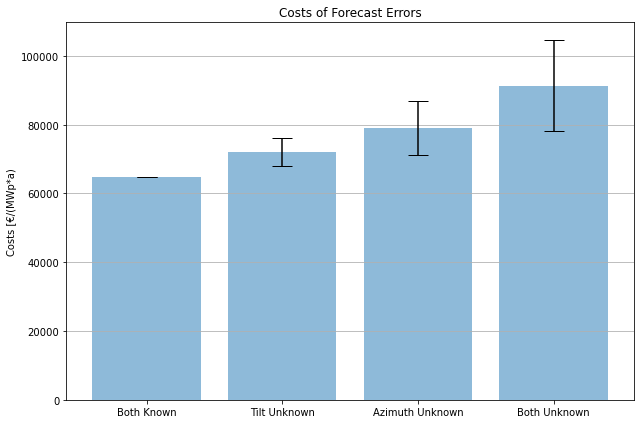

In [ ]:
import matplotlib.pyplot as plt


x_pos = range(len(labels))
# Build the plot
fig, ax = plt.subplots(figsize= (9,6))
ax.bar(x_pos, mean, yerr=errors, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Costs [€/(MWp*a)')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Costs of Forecast Errors')
ax.yaxis.grid(True)
# Save the figure and show
plt.tight_layout()
plt.savefig('costs_of_forecasts.png')
plt.show()